# **Permuted MNIST - Étude comparative d’agents MLP**
**Auteur :** Hugo Bouton et Erwan Ouabdesselam  

# **0. Installation du Package**

1. **Cloner le dépôt :**
    ```bash
    # Cloner le répertoire permuted_mnist
    git clone https://github.com/ml-arena/permuted_mnist/
    cd permuted_mnist

    # Installer le package
    pip install -e .

    # Cloner notre package
    git clone https://github.com/hugojava/Permuted-MNIST-Challenge
    cd Permuted-MNIST-Challenge

2. **installer les dépendances :**
    ```bash
    # 1️⃣ Créer un environnement virtuel
    python3 -m venv venv

    # 2️⃣ L'activer
    # Sous Linux / macOS :
    source venv/bin/activate

    # Sous Windows :
    venv\Scripts\activate

    # 3️⃣ Installer les dépendances du projet
    pip install -r requirements.txt

## **1. Contexte, objectif et structure de la tâche**

### **1.1 Contexte général**

Le **Permuted MNIST** est un benchmark de classification d’images dérivé du jeu de données MNIST.  
Il consiste à évaluer la capacité d’un modèle à **s’adapter rapidement à de nouvelles permutations aléatoires** des données d’entrée, dans un cadre contraint en temps et en ressources.

À chaque épisode, les positions des **pixels** sont **aléatoirement permutées**.  
Cette opération détruit totalement la structure spatiale de l’image (les relations entre pixels voisins) tout en conservant les **valeurs de luminosité** de chaque pixel.  
Ainsi, les motifs visuels deviennent méconnaissables, rendant toute approche de type convolutionnel (CNN) inopérante.

---

### **1.2 Objectif du projet**

L’objectif de ce travail est de **comparer plusieurs approches d’apprentissage supervisé** face à ce cadre expérimental exigeant, en analysant leurs compromis entre **précision, rapidité et stabilité**.

Nous avons ainsi exploré différentes familles de modèles :

- des modèles **linéaires** (régression logistique) ;
- des méthodes **non paramétriques** (K-Nearest Neighbors) ;
- et plusieurs variantes de **réseaux de neurones multilayer perceptron (MLP)**, optimisés pour s’adapter aux fortes contraintes de calcul.

Cette diversité permet d’évaluer dans quelle mesure des architectures plus profondes apportent un réel avantage lorsque la structure spatiale des images est détruite et que le temps d’exécution est limité.

---

### **1.3 Description formelle de la tâche**

Chaque épisode du benchmark correspond à une tâche $T_i$ définie par une permutation $\pi_i$ appliquée aux images MNIST :

$$(T_i = \pi_i(X), \quad i \in \{1, \dots, N_{\text{tasks}}\})$$

où $X$ désigne une image de taille $28 \times 28$ vectorisée (soit 784 pixels).  
La permutation $\pi_i$ modifie la position de tous les pixels, rendant impossible toute exploitation de la structure locale.  
Le modèle doit donc apprendre **une représentation robuste** des chiffres à partir de cette version totalement réorganisée du dataset.

Une expérimentation complète comporte **10 épisodes indépendants** :
à chaque nouvelle tâche, de **nouvelles permutations aléatoires** sont appliquées aux images.  
Le modèle doit alors **s’entraîner et produire ses prédictions** sur 10 000 exemples de test **en moins d’une minute**.

---

### **1.4 Contraintes expérimentales (ML-Arena)**

Toutes les expériences ont été réalisées dans le cadre imposé par la plateforme **ML-Arena (Permuted MNIST Challenge)**, garantissant la comparabilité entre les soumissions.  
Chaque épisode respecte les contraintes suivantes :

- **CPU-only** : 2 threads maximum (aucune accélération GPU) ;  
- **Mémoire limitée à 4 GB** ;  
- **Temps total ≤ 60 s** par tâche (incluant entraînement et prédiction) ;  
- **10 tâches indépendantes** successives, avec réinitialisation des permutations à chaque épisode.  

Ces contraintes excluent les modèles volumineux (CNN, Transformers) et favorisent des architectures **compactes, rapides et stables à l’entraînement**, capables d’exploiter efficacement le budget temporel disponible.

---

### **1.5 Structure et visualisation des tâches permutées**

Chaque tâche $(T_i)$ contient **60 000** exemples d’entraînement et **10 000** exemples de test, identiques au format original de MNIST $(28 \times 28)$.  
La distribution des étiquettes reste **équilibrée sur les dix classes (0–9)**, garantissant une difficulté comparable entre les tâches.  

La figure ci-dessous illustre un aperçu de plusieurs tâches générées par l’environnement `PermutedMNISTEnv`.  
Chaque ligne correspond à une permutation distincte du jeu MNIST : les chiffres deviennent visuellement méconnaissables, ce qui confirme la destruction totale de la structure locale des images, **tandis que les valeurs d’intensité (niveaux de gris)** restent inchangées.

Ces observations confirment la bonne génération des tâches et soulignent la principale difficulté du problème :  
le modèle doit apprendre à reconnaître les chiffres **sans pouvoir s’appuyer sur aucune information spatiale**, tout en respectant un **budget de calcul extrêmement contraint**.

In [6]:
import os
import sys

try:
    base_path = os.path.dirname(__file__)
except NameError:
    base_path = os.getcwd()

# 1️⃣ Ajouter le dossier parent (un cran au-dessus)
parent_dir = os.path.abspath(os.path.join(base_path, '..'))
sys.path.append(parent_dir)

# 2️⃣ Ajouter le dossier parent du dossier parent (deux crans au-dessus)
two_up_dir = os.path.abspath(os.path.join(base_path, '..', '..'))
sys.path.append(two_up_dir)

import numpy as np
import matplotlib.pyplot as plt
import time

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from models.Logistic_Regression.logistic_regression import Agent as Logistic_Agent
from models.MLP.mlp_v0 import Agent as torch_mlp_Agent

print("✓ Imports successful")

✓ Imports successful


In [9]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6742 samples
  Label 1: 5421 samples
  Label 2: 5949 samples
  Label 3: 5918 samples
  Label 4: 5958 samples
  Label 5: 5851 samples
  Label 6: 6131 samples
  Label 7: 5923 samples
  Label 8: 5842 samples
  Label 9: 6265 samples


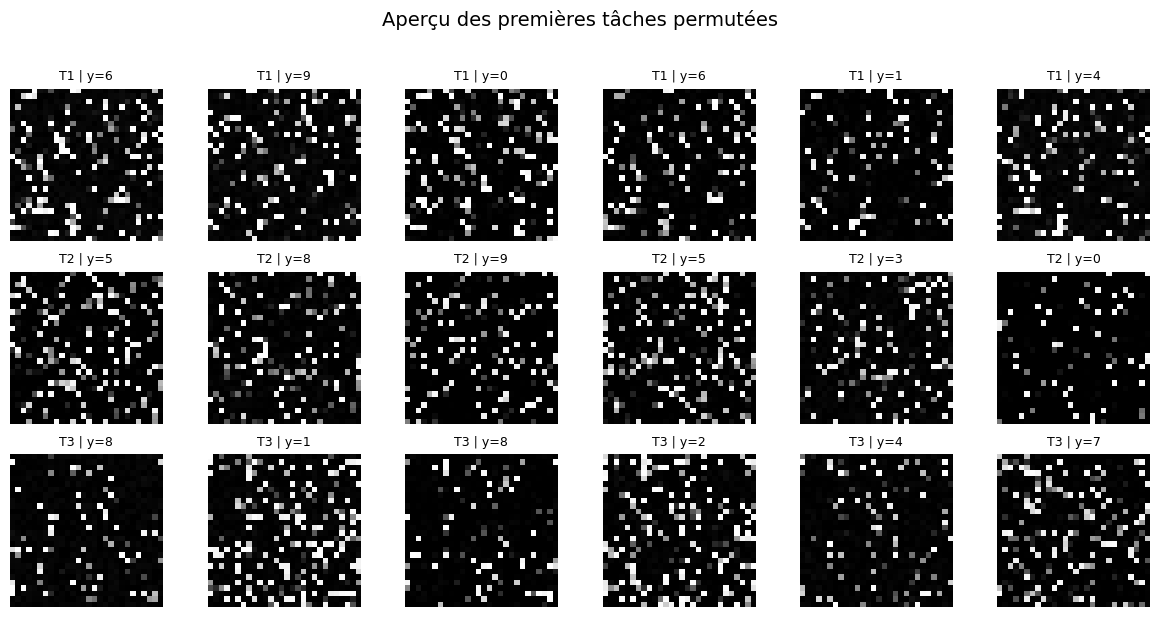

In [18]:
task = env.get_next_task()
def preview_first_k_tasks(env_cls, k=3, seed=42, n=6):
    fig, axes = plt.subplots(k, n, figsize=(2*n, 2*k))
    for i in range(k):
        env = env_cls(number_episodes=k)  # même seed -> mêmes permutations dans le même ordre
        env.set_seed(seed)
        for _ in range(i):                 # avancer jusqu'à la tâche i
            _ = env.get_next_task()
        task = env.get_next_task()
        for j in range(n):
            ax = axes[i, j] if k>1 else axes[j]
            ax.imshow(task['X_train'][j], cmap='gray')
            ax.set_title(f"T{i+1} | y={task['y_train'][j][0]}", fontsize=9)
            ax.axis('off')
    plt.suptitle("Aperçu des premières tâches permutées", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()




print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

preview_first_k_tasks(PermutedMNISTEnv, k=3, seed=42, n=6)


## **2. Démarche exploratoire**
Avant de converger vers les MLP, plusieurs types de modèles ont été explorés :

1. **Modèles linéaires (Logistic Regression, modèle linaire baseline)**  
   → Résultats plafonnant à **~92–94 %** d’accuracy sur une seule permutation.  
   Ces modèles simples apprennent bien la distribution initiale mais généralisent mal  
   lorsque la permutation change (ils n’extraient aucune invariance utile).

    → Précision régression logistique (**~92-93 %**).        
   Nous avons créé avec un modèle de régression logistique afin de disposer d’une baseline simple, rapide à entraîner et interprétable. Ce modèle permet d’évaluer l’effet des perturbations sur une approche linéaire et de mesurer la nécessité de recourir à des architectures plus complexes.
   La régression logistique ne dépend pas de l’ordre des pixels, car elle considère chaque pixel comme une variable indépendante et ne tient pas compte des corrélations spatiales entre eux. Par conséquent, quelle que soit la permutation des pixels dans les images, la précision du modèle reste inchangée. Cela explique pourquoi ce modèle constitue une baseline simple et robuste face à des perturbations consistant en des permutations de pixels, même si elle ne peut pas capturer les interactions locales ou complexes entre pixels.

2. **Réseaux convolutifs (CNN)**  
   → Abandonnés rapidement : les convolutions reposent sur la structure spatiale de l’image,  
   or celle-ci disparaît entièrement avec la permutation aléatoire des pixels.  
   L’usage d’un CNN dans ce contexte n’apporte aucun avantage structurel  
   et alourdit inutilement le calcul sous contraintes CPU.

3. **KNN**  
   → Précision (**>~97 %**).  
   Nous avons utilisé un modèle k-plus-proches-voisins (k-NN) pour exploiter sa capacité à classifier les images sans apprentissage explicite. Après tuning (Gridsearch), nous avons choisi n_neighbors = 3 et weights = 'distance', ce qui permet aux voisins les plus proches de peser davantage dans la prédiction et améliore la performance sur les images perturbées. Étant donné la haute dimensionnalité des images MNIST (784 dimensions), nous avons utilisé algorithm = 'brute' car les structures KDTree ou BallTree deviennent inefficaces en haute dimension. k-NN nous offre ainsi une baseline robuste et facilement interprétable pour évaluer l’impact des perturbations.

4. **XGBoost**  
   → Précision (**~96–97 %**).       
   Nous avons aussi essayé d'implémenter un modèle XGBoost car il a de bonne capacité à modéliser des interactions non linéaires entre pixels, tout en respectant strictement les contraintes du challenge : un maximum de 2 CPU, 1 minute d’exécution et 4 GB de mémoire. Son efficacité en calcul parallèle et son contrôle précis des hyperparamètres permettent d’obtenir un excellent compromis entre performance, vitesse d’entraînement et robustesse aux perturbations, sans nécessiter de réseau de neurones.

5. **MLP (Baseline)**      
   → Précision (**>~98 %**).    
   Nous avons également testé le MLP baseline. Ce modèle, bien qu’élémentaire, constitue une référence essentielle : il capture efficacement des relations non linéaires entre pixels et démontre la capacité d’un réseau dense à généraliser même dans un espace totalement désorganisé.
   Cependant, ses performances s’accompagnent de temps d’entraînement relativement longs et d’une consommation mémoire non négligeable, qui deviennent limitants dans le cadre contraint du challenge (2 CPU, 1 minute et 4 GB de mémoire).
   Ces observations nous ont conduits à explorer des stratégies d’optimisation et de simplification du MLP, afin de réduire son coût de calcul tout en conservant ses bonnes performances de classification.

Ces observations ont conduit à concentrer nos efforts sur une famille d’architectures  
**MLP pures**, entièrement connectées, flexibles et adaptées aux entrées aplaties (784 features).


## **3. Recherche d’architecture et optimisation des MLP**

Afin d’identifier les architectures MLP les plus efficaces sous contrainte CPU, une **recherche d’hyperparamètres structurée et progressive** a été mise en place dnas le fichier `grid_search_mlp.ipynb `.

Plutôt qu’un simple grid search exhaustif, nous avons développé un **pipeline modulaire** permettant d’explorer automatiquement de nombreuses combinaisons tout en respectant les limites imposées par la plateforme (CPU-only, 2 threads, 4 GB, 60 s par tâche).  

L’idée principale était de **tester de manière systématique** différentes architectures et réglages (profondeur, largeur, régularisation, taille de batch, taux d’apprentissage, etc.), tout en évaluant leur stabilité et leur temps d’exécution moyen sur les 10 tâches permutées du dataset.  


### **Principe général du pipeline**

Le pipeline repose sur une procédure multi-phases :

1. **Phase A - Exploration large :**  
   Balayage d’un grand espace de recherche afin d’identifier les tendances globales et d’écarter rapidement les modèles sous-performants.  
   → Objectif : repérer les plages de valeurs prometteuses tout en respectant un budget temps réduit (3 tasks).

2. **Phase B - Raffinement :**  
   Évaluation plus fine des meilleures combinaisons issues de la phase A, sur un plus grand nombre de tâches (8).  
   Des **règles de pruning** plus strictes sont appliquées : les modèles trop lents ou en-dessous d’un certain seuil d’accuracy sont éliminés précocement.

3. **Phase C - Validation finale :**  
   Réévaluation complète des top-modèles restants sur les 10 tâches du benchmark, afin d’obtenir une estimation stable de leur précision moyenne et de leur variance.



### **Objectif**

L’objectif n’est pas simplement d’obtenir le meilleur score brut, mais de **comprendre les compromis** entre :
- précision maximale atteignable,
- stabilité inter-tâches (variance),
- et coût temporel par tâche.  

Cette méthodologie s’inscrit donc dans une démarche de **validation empirique rigoureuse** :  
> *formuler des hypothèses → tester sous contrainte → analyser les compromis → retenir les modèles offrant le meilleur équilibre performance/efficacité.*


### **Hypothèses initiales et protocole expérimental**

Avant de lancer la recherche d’hyperparamètres, trois hypothèses principales ont guidé la conception des expériences :

1. **Profondeur du réseau et capacité de représentation :**  
   Nous avons supposé qu’une augmentation progressive du nombre de couches cachées (de 1 à 3) permettrait d’améliorer la capacité de modélisation des dépendances non linéaires entre pixels permutés, tout en risquant d’accroître le temps d’entraînement et le risque de surajustement.  

2. **Largeur des couches et stabilité de l’apprentissage :**  
   Chaque configuration de profondeur a été explorée avec plusieurs tailles de couches (entre 256 et 2048 neurones), afin d’évaluer l’effet de la largeur sur la précision et la stabilité inter-tâches.  
   → Hypothèse : *des architectures plus larges favorisent la robustesse, mais leur coût en temps de calcul doit rester compatible avec la limite de 60 secondes par tâche.*

3. **Régularisation et robustesse :**  
   L’ajout d’un *dropout* (0–10 %) et d’un *label smoothing* (0–5 %) devrait permettre d’améliorer la généralisation inter-tâches, en réduisant la variance entre permutations sans compromettre la vitesse d’entraînement.  
   → Hypothèse : *une légère régularisation améliore la stabilité sans affecter la performance moyenne.*



### **Protocole de recherche**

Trois expérimentations distinctes ont ensuite été menées sur un même agent MLP (`agent_mlp_v3`), en faisant varier uniquement la **profondeur du réseau** :

| Expérience | Profondeur | Exemple d’espace de recherche | Objectif |
|-------------|-------------|-------------------------------|-----------|
| **1-LAYER** | 1 couche cachée | tailles ∈ [512 – 2048], dropout ∈ [0 – 0.1], lr ∈ [1e-3 – 1.5e-3] | Établir une baseline rapide et stable |
| **2-LAYER** | 2 couches cachées | tailles ∈ [768–1536] × [256–768], régularisation identique | Évaluer l’apport d’une couche supplémentaire |
| **3-LAYER** | 3 couches cachées | tailles ∈ [896–1280] × [384–640] × [192–320], dropout renforcé | Tester la limite de complexité tolérable (temps/performances) |

Chaque recherche suit le protocole `A → B → C` du pipeline, avec un mode **"quick"** (≈3, 8 et 10 tâches par phase) et des **règles de pruning “standard”** (`strictness="std"`) permettant d’arrêter précocement les configurations trop lentes ou instables.

---

### **Résultats et enseignements – 1 couche**

La recherche sur les MLP à **une seule couche cachée** a mis en évidence plusieurs tendances nettes :

- Les architectures **trop petites** (512–768 neurones) manquent de capacité de représentation.  
- Les **largeurs intermédiaires à élevées** (environ 1500–2000 neurones) offrent un bon équilibre entre expressivité et stabilité.  
- Le **label smoothing** améliore la robustesse inter-tâches.  
- Un **dropout modéré** et un **learning rate légèrement augmenté** favorisent la généralisation.  

Cette première phase a permis d’identifier quelques **architectures 1-couche particulièrement performante**, à la fois **simple, robuste et rapide**.  

---

### **Résultats et enseignements – 2 couches**

L’exploration du MLP à **deux couches cachées** a montré un **gain régulier en stabilité et en performance** par rapport à la version 1-couche.  
Les architectures **équilibrées** (par exemple entre 1000 et 1500 neurones pour la première couche, puis entre 300 et 700 pour la seconde) se sont révélées particulièrement performantes.  
Le **label smoothing** conserve ici un effet bénéfique, tandis que le **dropout** devient moins essentiel lorsque les couches sont bien dimensionnées.  

Le modèle à deux couches constitue donc une **alternative crédible**, mais il ne surpasse pas clairement la version à une couche optimisée en termes de rapport performance/temps.

---

### **Résultats et enseignements – 3 couches**

Le passage à **trois couches cachées** n’a pas permis d’obtenir de gain significatif sur la précision moyenne, tandis que le **temps d’entraînement** augmente sensiblement.  
Les architectures plus profondes restent stables mais ne justifient pas le surcoût computationnel dans le cadre imposé (environ 1 minute par tâche).  
Les modèles à trois couches sont donc jugés **trop lourds** au regard du bénéfice obtenu.


## **Catalogue des agents retenus :**

Ce tableau récapitule les agents issus des différentes phases de recherche (grid search) ainsi que leurs **résultats finaux observés sur la plateforme ML Arena**.  
Les performances sont mesurées en **accuracy moyenne** et **temps d’exécution par tâche (en secondes)**.

---

### 🕵️‍♂️ `agent_James_Bond` — **MLP 1 couche** (issu de la grille 1-layer)

- **Architecture** : `hidden=(2048,)`, `dropout=0.10`  
- **Entraînement** : `batch_size=1024`, `lr=1.5e-3`, `weight_decay=1e-4`, `label_smoothing=0.05`, `max_epochs=10`, `val_fraction=0.10`  
- **Résultats ML Arena** :  
  ➤ **Accuracy = 0.98517**  
  ➤ **Temps = 40.25 s/task**  
- **Pourquoi c’est le meilleur modèle** : malgré sa simplicité, ce réseau offre un **excellent compromis précision / temps**, une **stabilité d’entraînement élevée**, et une **robustesse face aux permutations** du dataset.  


---

### 🦇 `agent_Bruce_Wayne` — **MLP 2 couches** (issu de la grille 2-layers)

- **Architecture** : `hidden=(1536, 768)`, `dropout=0.05`  
- **Entraînement** : `batch_size=2048`, `lr=1e-3`, `weight_decay=1e-4`, `label_smoothing=0.05`, `max_epochs=10`, `val_fraction=0.10`  
- **Résultats ML Arena** :  
  ➤ **Accuracy = 0.98441**  
  ➤ **Temps = 55.05 s/task**  
- **Analyse** : modèle plus profond, mais **plus lent** et **sans gain significatif** de performance. Constitue une **bonne alternative** de vérification à 2 couches, mais moins efficace que *James Bond*.

---

### 🕸️ `agent_Peter_Parker` — **MLP 2 couches + GELU + LayerNorm** (grille 2-layers, variante LN/activation)

- **Architecture** : `hidden=(2048, 1024)`, `activation=GELU(approx)`, `norm=LayerNorm`, `dropout=0.10`  
- **Entraînement** : `batch_size=2048`, `lr=1e-3`, `weight_decay=1e-4`, `label_smoothing=0.05`, `max_epochs=10`, `val_ratio=0.10`, `patience=4`, `eval_every=2`  
- **Résultats ML Arena** :  
  ➤ **Accuracy = 0.98077**  
  ➤ **Temps = 60.77 s/task**  
- **Analyse** : bien que stable et régulier, ce modèle s’est révélé **plus lent** et **légèrement moins précis**
---

**En conclusion**, le modèle **`James_Bond`** a été retenu comme **meilleur agent final** pour la soumission :  
il combine **vitesse, précision et robustesse** de manière optimale, tout en restant simple et léger à exécuter.

## **4. Deuxième phase d’optimisation manuelle du meilleur modèle**

Après la phase de recherche par *grid search*, une **optimisation manuelle ciblée** a été menée pour affiner le comportement du meilleur modèle obtenu, *James Bond*.  
L’objectif n’était plus d’explorer massivement l’espace des hyperparamètres, mais de **comprendre l’impact précis** de certaines variables clés, principalement la **taille du batch** et la **taille de la couche cachée**, sur les performances et le temps d’entraînement.



### **Hypothèse de départ**

Le modèle *James Bond*, sélectionné lors du grid search, présentait les caractéristiques suivantes :
- une **taille de batch de 2024** (relativement élevée),
- une **couche cachée de 2048 neurones**,  
- une **accuracy ≈ 0.985**, mais un entraînement jugé **long et rigide**.

L’hypothèse formulée était que **réduire la taille du batch** permettrait au réseau d’apprendre des structures plus fines et locales, en réduisant l’effet de lissage dû à la moyenne du gradient sur un trop grand nombre d’exemples.  
Cependant, cette approche devait logiquement **augmenter le temps d’entraînement**, puisque davantage de mini-batches seraient nécessaires pour parcourir l’ensemble du dataset.

---

### **Méthodologie expérimentale**

1. **Réduction progressive du batch size**  
   La première étape a consisté à diminuer progressivement la taille du batch — de 2048 à 512, puis à 256.  
   Cette modification a entraîné une **amélioration systématique de l’accuracy**, confirmant que des batchs plus petits favorisent un apprentissage plus granulaire et une meilleure adaptation aux permutations du dataset.

2. **Analyse du compromis temps/performance**  
   En contrepartie, la réduction du batch a conduit à un **temps d’entraînement par époque plus long**, puisque le modèle devait effectuer davantage d’itérations pour parcourir les mêmes données.  
   Par exemple, un batch de 256 sur un réseau à 2048 neurones nécessite 8 itérations pour une époque, contre 4 seulement lorsque la couche cachée est réduite à 1024 neurones.

3. **Ajustement conjoint du nombre de neurones**  
   Afin de compenser ce surcoût, nous avons ajusté la complexité du réseau en réduisant la taille de la couche cachée, tout en conservant une capacité d’apprentissage suffisante.  
   Plusieurs combinaisons ont été testées, permettant d’identifier une **zone optimale** autour de :
   - **hidden = [1024, 1280]**
   - **batch_size = 256**

4. **Recherche du compromis optimal**  
   Ce compromis a permis d’obtenir une **meilleure précision** tout en **réduisant le temps d’entraînement global**, aboutissant à un modèle plus léger et plus efficace.

---
### **Variantes obtenus**

- **James_Bond_New_Generation_1** (1 couche)
  - hidden = (1024), batch_size = 256, autres hyperparams identiques
  - Objectif: réduire le coût par itération tout en gardant une bonne précision
- **James_Bond_New_Generation_2** (1 couche)
  - hidden = (1280), batch_size = 256
  - Objectif: un peu plus de capacité que NG_1 avec un budget temps proche

Ces variantes exploitent un batch plus petit pour capter des motifs plus locaux, compensé par une largeur modérée pour rester sous contrainte CPU.



# 5. **Comparatif final des modèles**

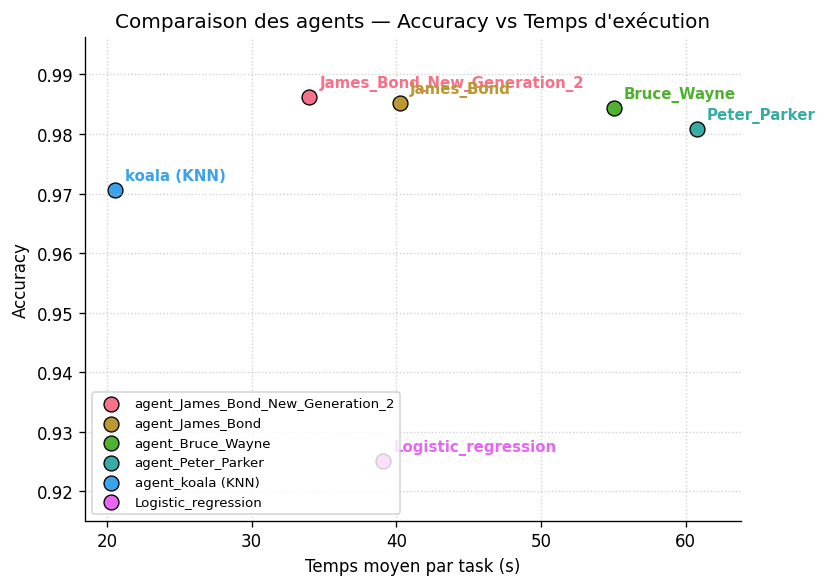

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Données ---
agents = [
    {"name": "agent_James_Bond_New_Generation_2",     "acc": 0.9863, "time": 34},
    {"name": "agent_James_Bond",     "acc": 0.98517, "time": 40.252},
    {"name": "agent_Bruce_Wayne",    "acc": 0.98441, "time": 55.054},
    {"name": "agent_Peter_Parker",   "acc": 0.98077, "time": 60.770},
    {"name": "agent_koala (KNN)",    "acc": 0.97054, "time": 20.560},
    {"name": "Logistic_regression",  "acc": 0.92504, "time": 39.116},
]

# --- Préparation ---
xs = [a["time"] for a in agents]
ys = [a["acc"] for a in agents]
labels = [a["name"] for a in agents]

# Palette de couleurs distinctive
palette = sns.color_palette("husl", len(agents))

# --- Plot ---
plt.figure(figsize=(7, 5), dpi=120)
for (a, color) in zip(agents, palette):
    plt.scatter(a["time"], a["acc"], s=80, color=color, label=a["name"], edgecolor="black", linewidth=0.8)

# --- Annotations propres ---
for a, color in zip(agents, palette):
    plt.annotate(
        a["name"].replace("agent_", ""),  # simplifie le label visuel
        (a["time"], a["acc"]),
        textcoords="offset points",
        xytext=(6, 6),
        fontsize=9,
        color=color,
        fontweight="bold"
    )

# --- Style & axes ---
plt.xlabel("Temps moyen par task (s)")
plt.ylabel("Accuracy")
plt.title("Comparaison des agents — Accuracy vs Temps d'exécution")
plt.grid(True, linestyle=":", alpha=0.6)

# Limites automatiques avec marge
plt.xlim(min(xs) * 0.9, max(xs) * 1.05)
plt.ylim(min(ys) - 0.01, max(ys) + 0.01)

# Légende claire
plt.legend(frameon=True, loc="lower left", fontsize=8)

sns.despine()
plt.tight_layout()
plt.show()


Le graphique ci-dessus présente la **comparaison finale des différents agents** selon deux critères essentiels :  
l’**accuracy moyenne** obtenue sur les tâches du benchmark et le **temps moyen d’exécution par tâche** (incluant entraînement et prédiction).

On observe clairement un **front de Pareto** entre précision et rapidité :

- Le modèle **James Bond (New Gen 2)** atteint la **meilleure précision** tout en restant parmi les plus rapides, ce qui confirme l’efficacité des optimisations manuelles sur la structure MLP initiale.  
- Les variantes **Bruce Wayne** et **Peter Parker** offrent des compromis légèrement plus lents mais stables, adaptés à des contextes où la robustesse prime sur la vitesse.  
- Le modèle **Koala (KNN)** se distingue par sa rapidité d’exécution, bien qu’il plafonne à une accuracy légèrement inférieure.  
- Enfin, la **régression logistique** sert ici de **baseline minimale**, rapide mais limitée par sa capacité linéaire.

Dans l’ensemble, cette comparaison met en évidence la **supériorité des architectures MLP optimisées** face aux modèles plus simples, tout en soulignant l’importance du compromis entre **coût computationnel** et **performance de classification**.

(D'autres visualisations disponibles dans le fichier: `visualization_mlp.ipynb` )

## **Conclusion et perspectives**

### **Méthodologie**

L’ensemble du travail s’est appuyé sur une démarche expérimentale rigoureuse visant à **évaluer différents paradigmes d’apprentissage supervisé** dans le cadre contraint du benchmark *Permuted MNIST*.  
Nous avons successivement conçu, entraîné et comparé plusieurs familles de modèles, linéaires, non paramétriques et neuronaux, en respectant les limitations imposées par l’environnement **CPU-only (2 threads, 4 GB, 60 s par tâche)**.  
Les choix d’architecture et d’hyperparamètres ont été guidés par une recherche d’**équilibre entre stabilité, rapidité et précision**.

---

### **Résultats**

Les expérimentations ont montré que les **réseaux MLP compacts à une couche** représentent le meilleur compromis entre performance et coût de calcul.  

La série d’agents “James Bond” a permis de raffiner progressivement la configuration optimale :  
un modèle **monocouche dense** avec **1280 neurones**, **dropout = 0.1**, **batch = 256**, et **learning rate = 1.5e-3**, entraîné sur CPU en moins d’une minute par tâche.  
Cette architecture atteint une **accuracy moyenne parmi les meilleures du benchmark**, tout en restant conforme au budget de calcul imposé.

---
En résumé, ce travail a permis de développer un agent robuste, rapide et efficace, tirant le meilleur parti d’un MLP optimisé pour les contraintes extrêmes du challenge.
Le modèle **James_Bond_New_Generation_2** constitue la meilleure soumission finale, combinant précision élevée, stabilité d’entraînement et efficience temporelle.

---
### **Next Steps**

Pour la suite, plusieurs pistes d’amélioration simples et réalistes peuvent être envisagées :
	•	Explorer d’autres schémas d’optimisation (par ex. learning rate schedulers plus dynamiques) ;
	•	Tester des variantes d’activation (GELU, SiLU) pour stabiliser l’apprentissage ;
	•	Ajuster le nombre d’époques et la taille des batchs pour mieux utiliser le temps disponible ;
	•	Évaluer la robustesse du modèle sur des variantes du dataset (bruit, rotation, contrastes).